In [ ]:
# import librarry
!pip install yfinance
!pip install --upgrade mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf 
import warnings
import datetime
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from scipy.stats import boxcox
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.optimize import minimize
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import shapiro, kstest, normaltest

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
start_day = '2017-01-01'
end_day = datetime.now().date()

In [ ]:
# Download market data from Yahoo! Finance's 
def download_data(ticker='MSFT', start='2017-01-01', end=datetime.now().date()):
  data = yf.Ticker(ticker)
  hist = data.history(start=start, end=end) # 
  hist.reset_index(inplace=True)
  hist['Date'] = hist['Date'].dt.date
  # hist['Date'] = hist['Date'].dt.strftime('%Y-%m-%d')
  hist.rename(columns={'Date': 'datetime'}, inplace=True)
  return hist.iloc[:, :5]

In [ ]:
# Pfizer download
PFE = download_data(ticker='PFE', start=start_day, end=end_day)
PFE.set_index('datetime', inplace=True)
PFE.head(), PFE.tail()

(                 Open       High        Low      Close
 datetime                                              
 2017-01-03  25.098157  25.328415  25.013729  25.328415
 2017-01-04  25.428191  25.597046  25.351438  25.550995
 2017-01-05  25.612399  25.858008  25.420516  25.796606
 2017-01-06  25.834980  25.865681  25.589372  25.696825
 2017-01-09  25.658451  25.842657  25.620073  25.689152,
                  Open       High        Low      Close
 datetime                                              
 2022-10-17  43.189999  43.810001  43.189999  43.650002
 2022-10-18  44.049999  44.360001  43.619999  44.090000
 2022-10-19  43.910000  44.070000  42.740002  43.110001
 2022-10-20  43.270000  43.410000  42.820000  42.910000
 2022-10-21  43.310001  45.160000  42.990002  44.950001)

In [ ]:
PFE.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1462 entries, 2017-01-03 to 2022-10-21
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1462 non-null   float64
 1   High    1462 non-null   float64
 2   Low     1462 non-null   float64
 3   Close   1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1+ KB


Посмотрим на характеристики временного ряда

In [ ]:
PFE.describe()

,Open,High,Low,Close
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,35.290647,35.639265,34.940070,35.295010
std,7.864344,8.029378,7.712141,7.880390
min,23.801032,24.146418,23.716603,23.908484
25%,29.395324,29.622250,29.178440,29.398808
50%,33.676075,33.875776,33.320462,33.595818
75%,37.558484,37.999925,37.388144,37.652051
max,59.196893,60.281193,58.444724,59.831844


In [ ]:
def data_plot(data, cols, start='2017-01-01', end=datetime.now().date()):
  # plt.figure(figsize=(12, 7))
  fig, ax = plt.subplots(figsize=(12, 7))
  start = pd.to_datetime(start)
  end = pd.to_datetime(end)
  for col in cols:
    ax.plot(data[start: end][col], label=col, linewidth=2)
    # plt.plot(data[start: end][col], linewidth=5.0)
  plt.xlabel('date')  
  ax.legend()
  plt.show()


In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh', start='2017-01-01', end=datetime.now().date()):
    if not isinstance(y, pd.Series):
        y = pd.Series(y[start: end])
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])      
        plt.tight_layout()



In [ ]:
def diki (otg):
  test = sm.tsa.stattools.adfuller(otg)
  print ('adf: ', test[0])
  print ('p-value: ', test[1])
  print ('Critical values: ', test[4])
  if test[0]> test[4]['5%']: 
      print ('есть единичные корни, ряд не стационарен')
  else:
      print ('единичных корней нет, ряд стационарен')

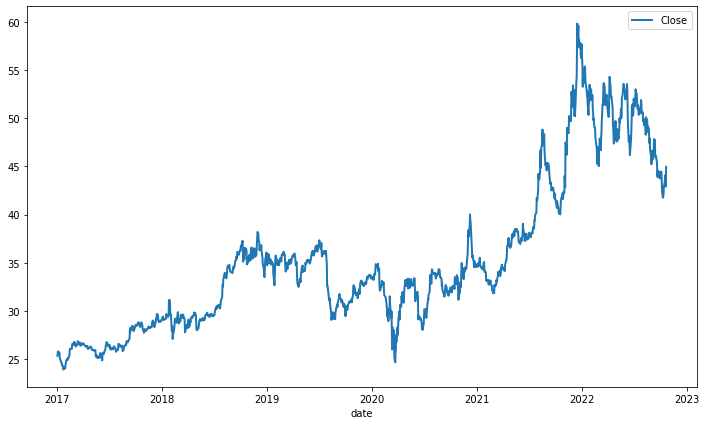

In [ ]:
data_plot(PFE, cols=['Close',], start='2017-01-01',)

По первому графику можно сказать, что процесс не стационарен, так как есть возврастающий и с конца 2021 начала 2022 года спадающий тренд, и матожидание со временем меняется. Наблюдается некоторая цикличность в данных.

На общем графике не заметны выбросы, построим график с 2019 года и до 2020 года сегодняшнего дня.

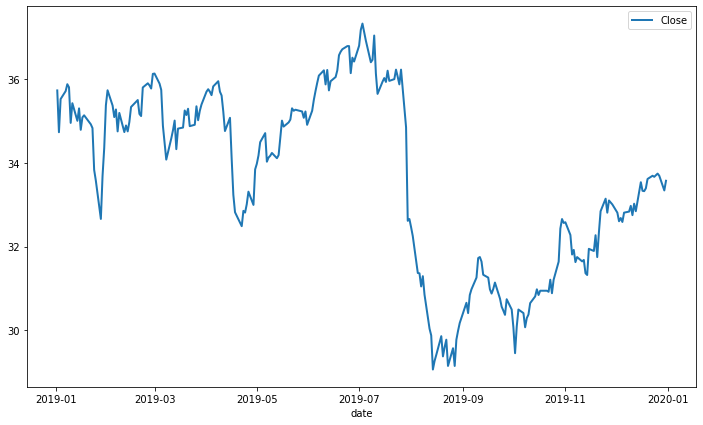

In [ ]:
data_plot(PFE, cols=['Close',], start='2019-01-01', end='2020-01-01')

На укрупленном графике так же не заметно каких-либо выбросов. Можно приблизительно оценить цикличность, которая составляет приблизительно 70-90 дней. Так как компания биофарм области, возможно обусловлена ростом заболеваемости, пандемиями и т.п.

In [ ]:
df1 = PFE.copy()

Проверим гипотезу, что процесс нестационарен с помощью теста Дики-Фуллера.

Критерий Дики-Фуллера: p=0.580602


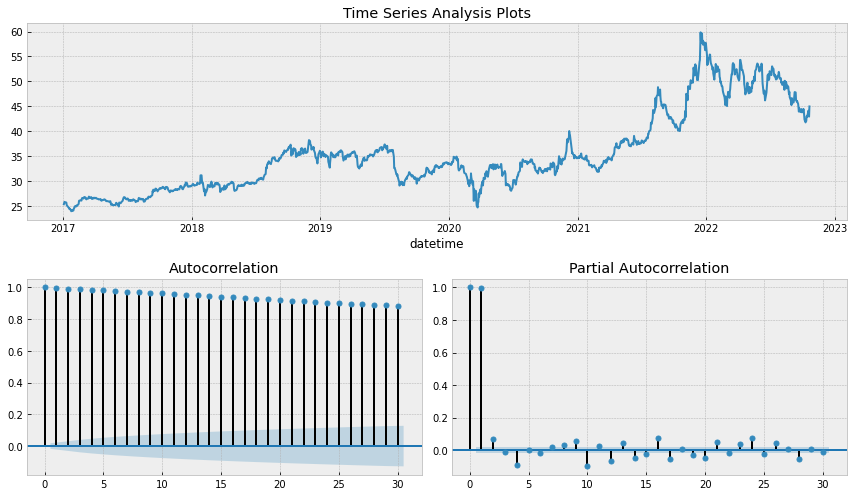

In [ ]:
tsplot(PFE.Close, lags=30)

In [ ]:
diki(PFE.Close)

adf:  -1.403488964795887
p-value:  0.5806023266439505
Critical values:  {'1%': -3.4349056408696814, '5%': -2.863552005375758, '10%': -2.5678411776130114}
есть единичные корни, ряд не стационарен


Как видим, наша гипотеза верна.

Попробуем стабилизировать дисперсию преоразованием Бокса-Кокса.

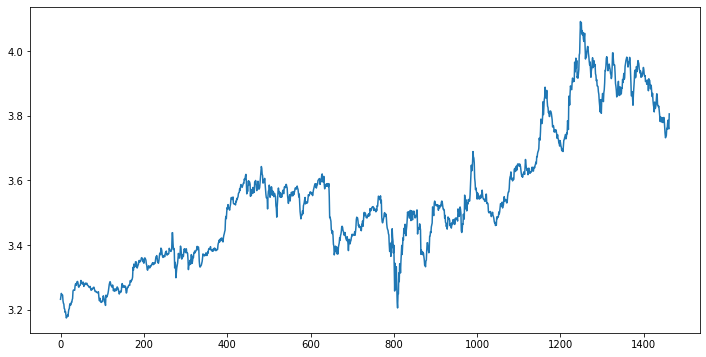

In [ ]:
modified = boxcox(PFE.Close, 0)
plt.figure(figsize=(12,6))
plt.plot(modified)
plt.show()

In [ ]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))


Критерий Дики-Фуллера: p=0.393340
Оптимальный параметр преобразования Бокса-Кокса: -1.426357


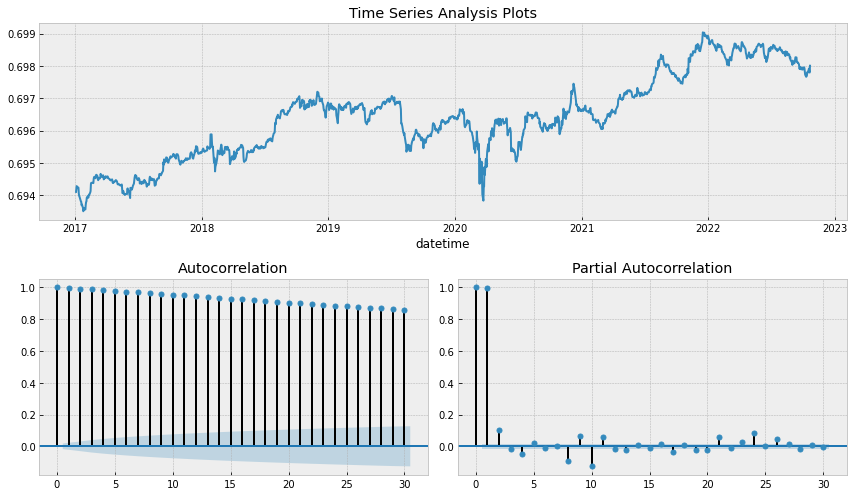

In [ ]:
data = PFE.copy()
data['Close_box'], lmbda = boxcox(data.Close) # 
tsplot(data['Close_box'], lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

лучше, но все еще процесс нестационарен. попробуем избавиться от сезонной составляющей. Для этого используем попарные разности

In [ ]:
# data['Close_season'] = data.Close_box - data.Close_box.shift(1)
# tsplot(data.Close_season[1:], lags=30)

Критерий Дики-Фуллера: p=0.000000


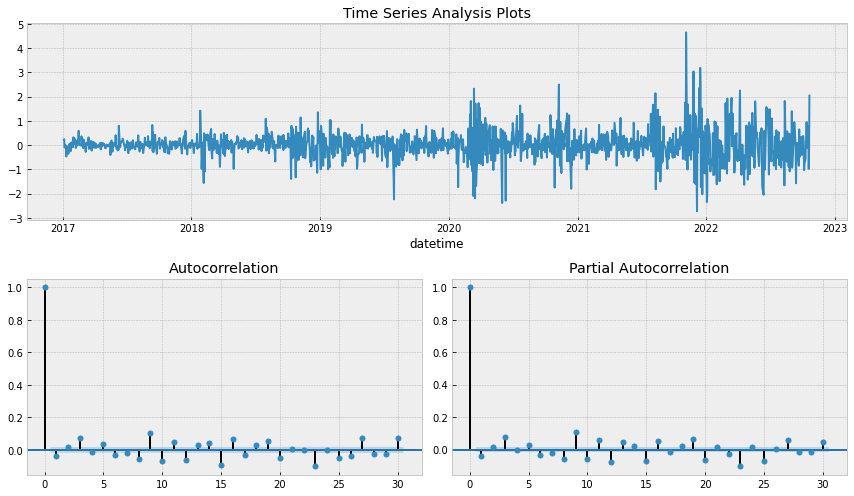

In [ ]:
otgdiff = data.Close.diff(periods=1).dropna()
tsplot(otgdiff, lags=30)

Временной ряд теперь стал стационарен.

Аналогичный анализ сделаем для Banco Bradesco S.A.

In [ ]:
BBD = download_data(ticker='BBD', start=start_day, end=end_day)
BBD.index.freq = 'd'
BBD.set_index('datetime', inplace=True)
BBD.head(), BBD.tail()

(                Open      High       Low     Close
 datetime                                          
 2017-01-03  5.443202  5.582461  5.425039  5.552188
 2017-01-04  5.582460  5.612734  5.546132  5.570351
 2017-01-05  5.594570  5.727774  5.576406  5.691445
 2017-01-06  5.655117  5.697500  5.630898  5.679336
 2017-01-09  5.715662  5.745935  5.691443  5.709607,
             Open  High   Low  Close
 datetime                           
 2022-10-17  3.78  3.80  3.73   3.75
 2022-10-18  3.82  3.83  3.74   3.80
 2022-10-19  3.76  3.82  3.75   3.79
 2022-10-20  3.86  3.90  3.84   3.86
 2022-10-21  3.86  4.04  3.86   3.99)

Посмотрим на характеристики временного ряда

In [ ]:
BBD.describe()

,Open,High,Low,Close
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,5.564817,5.642171,5.481529,5.562610
std,1.721721,1.732534,1.709031,1.724005
min,2.555679,2.729722,2.454917,2.628961
25%,3.920082,3.987948,3.840233,3.908521
50%,5.338230,5.397570,5.228850,5.311432
75%,7.053421,7.155442,6.982451,7.077750
max,9.124695,9.152831,8.961966,9.055468


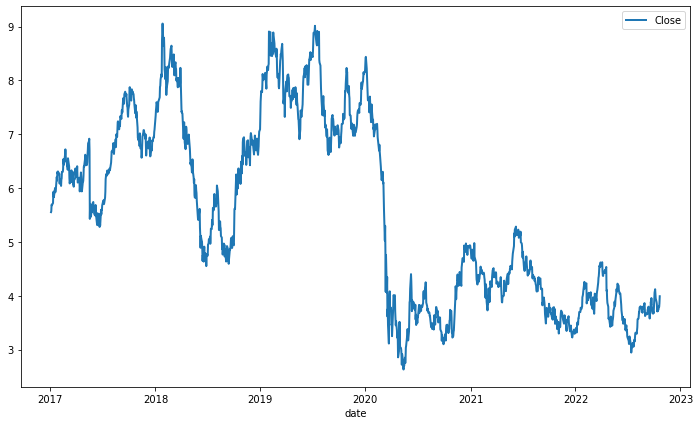

In [ ]:
data_plot(BBD, cols=['Close',], start='2017-01-01', )

По графику можно сказать, что процесс не стационарен, так как есть возврастающий тренд и матожидание со временем растет. Наблюдается некоторая цикличность в данных.

На общем графике не заметны выбросы, построим график с 2021 года и до сегодняшнего дня.

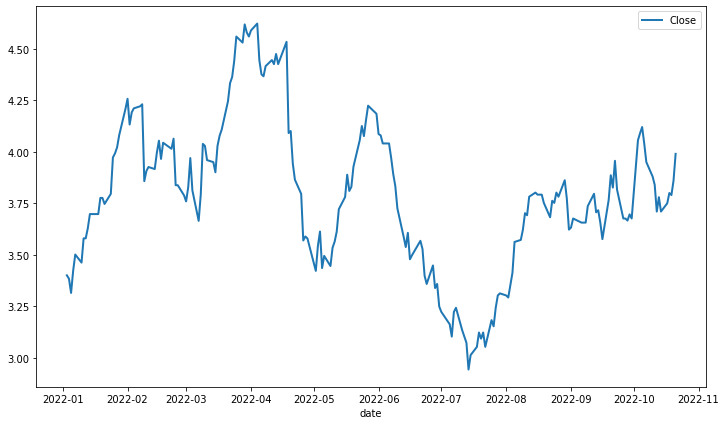

In [ ]:
data_plot(BBD, cols=['Close'], start='2022-01-01')

На графике не видны какие-либо выбросы, по графику заметна сезонность около 70-80 дней

Проверим гипотезу, что процесс нестационарен с помощью теста Дики-Фуллера.

Критерий Дики-Фуллера: p=0.517863


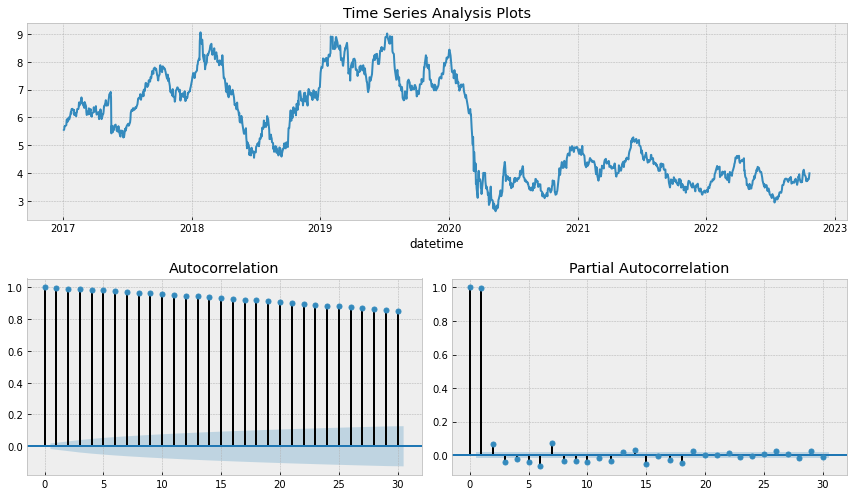

In [ ]:
tsplot(BBD.Close, lags=30)

In [ ]:
diki(BBD.Close)

adf:  -1.53152547229053
p-value:  0.5178625208832824
Critical values:  {'1%': -3.4348523191002123, '5%': -2.8635284734563364, '10%': -2.567828646449617}
есть единичные корни, ряд не стационарен


Как видим, наша шипотеза верна.

Попробуем стабилизировать дисперсию преоразованием Бокса-Кокса.

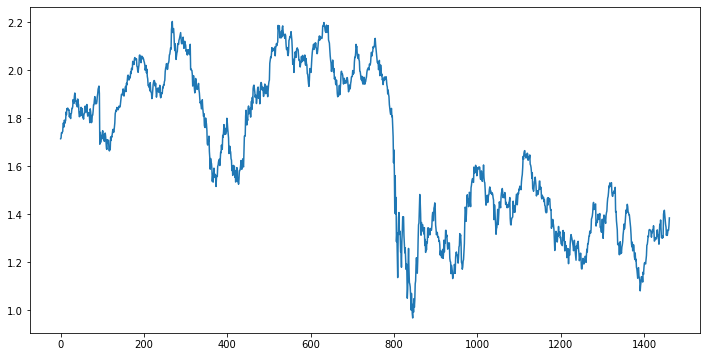

In [ ]:
modified = boxcox(BBD.Close, 0)
plt.figure(figsize=(12,6))
plt.plot(modified)
plt.show()

Критерий Дики-Фуллера: p=0.376495
Оптимальный параметр преобразования Бокса-Кокса: 0.168219


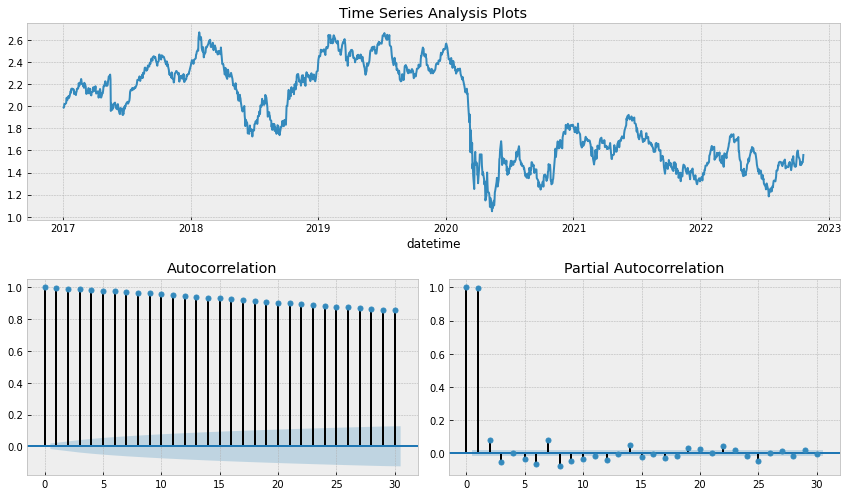

In [ ]:
data = BBD.copy()
data['Close_box'], lmbda = boxcox(data.Close) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data['Close_box'], lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Ряд все еще остается не стационарным, попробуем убрать нестационарность пеейдя к попарным разностям. 

Критерий Дики-Фуллера: p=0.000000


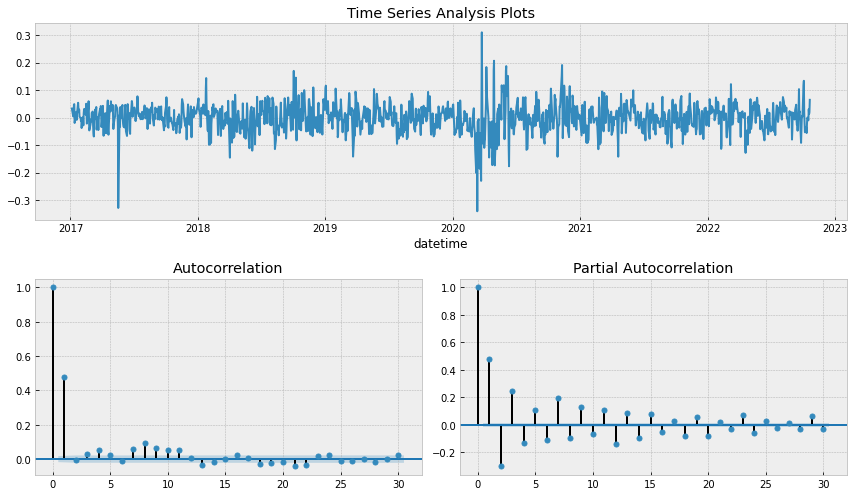

In [ ]:
data['Close_season'] = data.Close_box - data.Close_box.shift(2)
tsplot(data.Close_season[2:], lags=30)